In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']  = '3'  # no debugging from TF
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'

import logging
logging.getLogger('tensorflow').disabled = True
logging.getLogger().setLevel(logging.INFO)

## Tensorflow
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Scanpy
import numpy as np
import pandas as pd
import scanpy as sc
import h5py

In [10]:
#### Set up tf config
gpu_device = '1'
os.environ["CUDA_VISIBLE_DEVICES"]  = gpu_device
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.allow_soft_placement = True
config.intra_op_parallelism_threads = 5
config.inter_op_parallelism_threads = 5

In [7]:
dataset = ['Trachea','fetal_liver_atlas']

In [8]:
data = dataset[0]
method = 'siVAE'
dir0 = '../'
dir1 = '{}'.format(data)

In [9]:
with h5py.File(os.path.join(dir0, 'datasets/co-expression/{}/{}.h5').format(data, data)) as data_mat:
    X = np.array(data_mat['X'])
    X = np.ceil(X).astype(np.float)
adata = sc.AnnData(X)
gene = pd.read_csv(os.path.join(dir0, 'datasets/co-expression/{}/{}_geneset.csv').format(data, data),
                   header=0).values.squeeze()
adata.var['feature_types'] = gene
celltype = pd.read_csv(
    os.path.join(dir0, 'datasets/co-expression/{}/{}_celltype.csv').format(data, data),
    header=None).values
celltype = np.array(celltype).squeeze()
adata.var_names = gene
adata.obs['Labels'] = celltype
print("number of cell type: {}".format(len(np.unique(adata.obs['Labels']))))
print(adata)

<ipython-input-9-78d226f88601>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(os.path.join(dir0, 'datasets/co-expression/{}/{}.h5').format(data, data)) as data_mat:
<ipython-input-9-78d226f88601>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.ceil(X).astype(np.float)


number of cell type: 7
AnnData object with n_obs × n_vars = 7193 × 18388
    obs: 'Labels'
    var: 'feature_types'


In [10]:
data = dataset[1]
method = 'siVAE'
dir0 = '../'
dir1 = '{}'.format(data)

In [11]:
adata0 = sc.read_h5ad(os.path.join(dir0, 'datasets/co-expression/{}/sample_fetal_liver_atlas_dataset.h5ad').format(data))
count = np.array(adata0.raw.X.todense())
adata = sc.AnnData(count)
adata.var_names = adata0.raw.var_names
adata.obs['Labels'] = np.array(adata0.obs['Cell.Labels'].values)
print("number of cell type:{}".format(len(np.unique(adata.obs['Labels']))))
adata.var['feature_types'] = adata.var_names
print(adata)

number of cell type:7
AnnData object with n_obs × n_vars = 500 × 28790
    obs: 'Labels'
    var: 'feature_types'


In [33]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=1000)
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)

/home/pai/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [34]:
from siVAE.data.data_handler import data2handler

datah_sample, datah_feature, plot_args = data2handler(adata)

#### Setup the train/test/validation split
k_split=0.8
datah_sample.create_split_index_list(k_split=k_split,random_seed=0)

In [35]:
#### Training Parameters
iter          = 2000
mb_size       = 0.2
l2_scale      = 1e-3
keep_prob     = 1
learning_rate = 1e-4
early_stop    = False
decay_rate    = 0.9

#### Model parameters
# Architecture should be a string with a specific format
# architecture: "Encoder-LE-Decoder-Output (0)-Index of LE"
architecture = '1024-512-128-LE-128-512-1024-0-3'
decoder_activation = 'NA'
zv_recon_scale = 0.1
LE_dim = 2
datah_sample.create_dataset(kfold_idx=0)

#### Set parameters

graph_args = {'LE_dim'       : LE_dim,
              'architecture' : architecture,
              'config'       : config,
              'iter'         : iter,
              'mb_size'      : mb_size,
              'l2_scale'     : l2_scale,
              'tensorboard'  : True,
              'batch_norm'   : False,
              'keep_prob'    : keep_prob,
              'log_frequency': 50,
              'learning_rate': learning_rate,
              "early_stopping"   : early_stop,
              "validation_split" : 0,
              "decay_rate"       : decay_rate,
              "decay_steps"      : 1000,
              'var_dependency'   : True,
              'activation_fun'   : tf.nn.relu,
              'activation_fun_decoder': tf.nn.relu,
              'output_distribution': 'normal',
              'beta'               : 1,
              'l2_scale_final'     : 5e-3,
              'log_variational'    : False,
              'beta_warmup'        : 1000,
              'max_patience_count' : 100}

logdir='out_test'
graph_args['logdir_tf'] = logdir
os.makedirs(logdir,exist_ok=True)

In [36]:
from siVAE.run_model import run_VAE

siVAE_output = run_VAE(graph_args_sample=graph_args,
                        LE_method='siVAE',
                        datah_sample=datah_sample,
                        datah_feature=datah_feature)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

not custom
not custom
not custom
not custom
not custom
not custom
not custom
not custom
Build output layer
h_dim: 1000
not custom
creating distribution
not custom
not custom
not custom
not custom
not custom
not custom
not custom
not custom
Build output layer
h_dim: 1024
not custom
creating distribution
not custom
Build output layer
h_dim: 1000
creating distribution
[<tf.Tensor 'VAE_sample/model/NN/Decoder/hidden_layer_0/layer/dense/Relu:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'VAE_sample/model/NN/Decoder/hidden_layer_1/layer/dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'VAE_sample/model/NN/Decoder/hidden_layer_2/mu/layer/None_mu/BiasAdd:0' shape=(?, 1024) dtype=float32>, <tf.Tensor 'VAE_sample/model/NN/Decoder/hidden_layer_3/output/layer/X_mu/BiasAdd:0' shape=(?, 1000) dtype=float32>]
[<tf.Tensor 'VAE_sample/model/NN/Encoder/hidden_layer_0/layer/dropout/mul_1:0' shape=(?, 1024) d

In [37]:
gene_embeddings = siVAE_output.get_feature_embeddings()
gene_names      = siVAE_output.get_model().get_value('var_names')

In [38]:
cell_embeddings = siVAE_output.get_sample_embeddings()

In [20]:
cell_embeddings.shape

(7193, 2)

In [16]:
gene_embeddings.shape

(1000, 2)

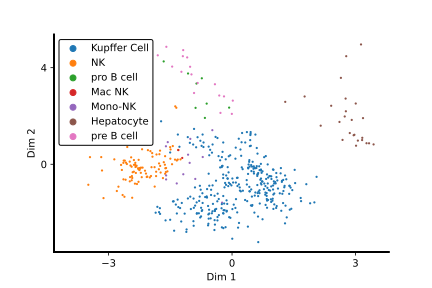

In [39]:
from siVAE.model.output import plot
from IPython.core.display import SVG

kwargs={'s':5,'edgecolor':"none"}

plot.plot_latent_embeddings(siVAE_output,logdir=logdir,
                            filename='CellEmbeddings.svg',
                            show_legend=True,
                            **kwargs)

SVG(filename=os.path.join(logdir,'CellEmbeddings.svg'))

In [ ]:
sc.pp.neighbors(adata, use_rep="feat")
sc.tl.umap(adata)

In [40]:
np.savez(os.path.join(dir0,"results/co-expression/{}_siVAE.npz".format(data)),
         data = adata.X,
         umap = cell_embeddings,
         E_feature = gene_embeddings,
         cell_type = adata.obs['Labels'],
         gene_name = gene_names,
         true = np.array(adata.obs['Labels'].values))

/home/pai/lib/python3.6/site-packages/numpy/lib/format.py:350: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
